# Assignment 1:
Loading the data:

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from numpy import transpose as trans
from scipy.linalg import block_diag

In [2]:
raceData = pd.read_csv("AllData.csv")

# Information about data set:
drivers = np.unique(np.array(raceData["driverId"]))
numDrivers = len(drivers)

## 1.1 Plotting

(0.0, 58.0)

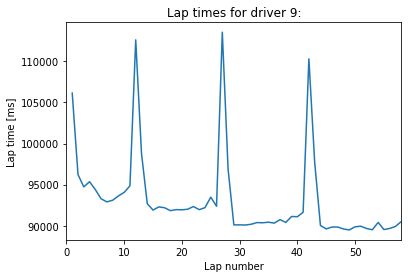

In [3]:
# Plotting data for given driver:
driverId = 9

raceDataDriver = raceData[raceData["driverId"] == driverId]

# Plot
plt.plot(raceDataDriver["lap_number"], raceDataDriver["lap_time"])
plt.title(f"Lap times for driver {driverId}:")
plt.xlabel("Lap number")
plt.ylabel("Lap time [ms]")
plt.xlim([0, len(raceDataDriver)])


(0.0, 58.0)

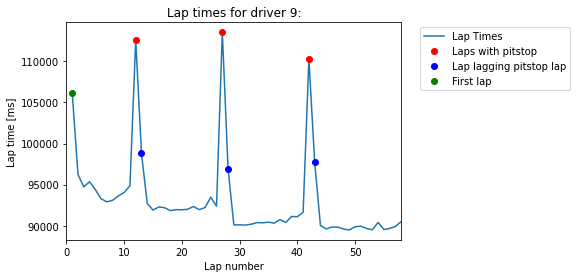

In [4]:
# Extract lap number and lap times of laps with pit stop and laps lagging that lap:
lapIsPitStop = np.array(raceDataDriver["pitstop"])
lapNumbers = np.array(raceDataDriver["lap_number"])
lapTimes = np.array(raceDataDriver["lap_time"])

lapsWithPitStopTime = []
lapsWithPitStop = []

lapsLaggingPitStopTime = []
lapsLaggingPitStop = []


# Extract the laps with pit stops
for lap in lapNumbers:
    if lapIsPitStop[lap-1]:
        lapsWithPitStop.append(lap)
        lapsWithPitStopTime.append(lapTimes[lap-1])

        lapsLaggingPitStop.append(lap+1)
        lapsLaggingPitStopTime.append(lapTimes[lap])


# Plot lap times with the pitstop marked:
plt.plot(lapNumbers, lapTimes)
plt.plot(lapsWithPitStop, lapsWithPitStopTime, 'ro')
plt.plot(lapsLaggingPitStop, lapsLaggingPitStopTime, 'bo')
plt.plot(lapNumbers[0], lapTimes[0], 'go')
plt.title(f"Lap times for driver {driverId}:")
plt.xlabel("Lap number")
plt.ylabel("Lap time [ms]")
plt.legend(["Lap Times", "Laps with pitstop", "Lap lagging pitstop lap", "First lap"], bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlim([0, len(raceDataDriver)])

## 1.2 OLS

Construct the X matrix and train the model:

In [38]:
# Parameters:
numTrain = 51
numTest = max(raceData["lap_number"]) - numTrain

# Useful information about the training set:
lapIsPitstopTrain = trans(np.array([raceData[raceData["lap_number"] <= numTrain]["pitstop"]]).astype(int))
lapIsLaggingPitstopTrain = trans(np.array([raceData[raceData["lap_number"] <= numTrain]["pitstop_lagged"]]))
lapIsFirstLapTrain = np.array(raceData[raceData["lap_number"] <= numTrain]["lap_number"] == 1).astype(int)
lapIsFirstLapTrain = trans(np.array([lapIsFirstLapTrain]))

numTrainingLaps =  len(raceData[raceData["lap_number"] <= numTrain])
numPitstopTrain = np.count_nonzero(lapIsPitstopTrain)
numLaggedPitstopTrain = np.count_nonzero(lapIsLaggingPitstopTrain)
numFirstLapTrain = np.count_nonzero(lapIsFirstLapTrain)
numNormalLaps = numTrainingLaps - numPitstopTrain - numLaggedPitstopTrain - numFirstLapTrain

drivers = np.unique(np.array(raceData["driverId"]))
numDrivers = len(drivers)

# Create the X matrix for training the model:
XTrain = np.array(pd.get_dummies(raceData[raceData["lap_number"] <= numTrain]["driverId"]))
XTrain = np.c_[XTrain, np.array(raceData[raceData["lap_number"] <= numTrain]["lap_number"])]
XTrain = np.c_[XTrain, np.array(raceData[raceData["lap_number"] <= numTrain]["pitstop"]).astype(int)]
XTrain = np.c_[XTrain, np.array(raceData[raceData["lap_number"] <= numTrain]["pitstop_lagged"])]
XTrain = np.c_[XTrain, (np.array(raceData[raceData["lap_number"] <= numTrain]["lap_number"]) == 1).astype(int)]

# Y vector for training:
YTrain = trans(np.array([raceData[raceData["lap_number"] <= 51]["lap_time"]]))

# Training the model:
parametersOLS = np.linalg.inv((trans(XTrain)@XTrain))@trans(XTrain)@YTrain
# Extracting the parameters:
alphaOLS = parametersOLS[:21]
betaOLS = parametersOLS[21]
deltaOLS = parametersOLS[22] # Parameter for pitstop laps
muOLS = parametersOLS[23] # Parameter for lap lagging pitstop
phiOLS = parametersOLS[24] # Parameter for first lap


Now I will make predictions on the test laps:

alpha: 93527.72 
 beta: -76.77 
 delta: 22000.77 
    mu: 7475.0 
 phi: 16310.25


<ipython-input-41-0d63882651a5>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]


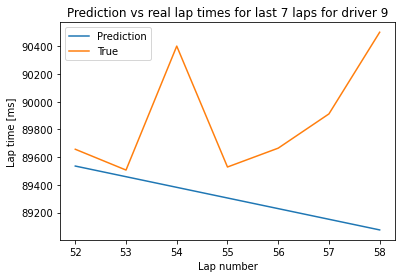

In [41]:
# Id for driver:
driverId = 9

# Extract the race data for the driver:
testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]

# Get the XTest and YTest:
lapNumbersDriverTest = np.array(testDataDriver["lap_number"])
lapTimesDriverTest = np.array(testDataDriver["lap_time"])

lapIsPitstopDriver = np.array(testDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(testDataDriver["pitstop_lagged"])
firstLap = np.array(testDataDriver["lap_number"] == 1).astype(int)

# Make the prediction:
predictionDriverOLS = alphaOLS[driverId - 1] + betaOLS * lapNumbersDriverTest + deltaOLS * lapIsPitstopDriver + muOLS * lapsLaggingPitStopDriver + phiOLS * firstLap

# Print the parameters:
print(f"alpha: {round(alphaOLS[driverId - 1][0], 2)} \n beta: {round(betaOLS[0], 2)} \n delta: {round(deltaOLS[0], 2)} \n\
    mu: {round(muOLS[0],2)} \n phi: {round(phiOLS[0], 2)}")

# Plot predictions and true value
plt.plot(lapNumbersDriverTest, predictionDriverOLS)
plt.plot(lapNumbersDriverTest, lapTimesDriverTest)
plt.title(f"Prediction vs real lap times for last {numTest} laps for driver {driverId}")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True"])


Now I calculate the sigma in order to provide a measure of uncertainty on the prediction.

#### Make predictions for all drivers on all data

In [7]:
# Make predictions on the training data for all drivers:
predictionAllDriversOLS = XTrain @ parametersOLS

N = len(YTrain) # Number of samples
p = len(parametersOLS) # Number of parameters

# Calculate the variance sigma2 and std sigma:
sigma2OLS = (trans(YTrain - predictionAllDriversOLS) @ (YTrain - predictionAllDriversOLS)) /(N - p)
sigmaOLS = np.sqrt(sigma2OLS)
print(sigmaOLS)

[[2398.56076001]]


In [51]:
# Variance of parameters:
varParameters = sigma2OLS * np.linalg.inv((trans(XTrain) @ XTrain))
print(np.sqrt(np.diag(varParameters)))

[368.76104198 368.76104198 369.56048811 368.76104198 369.56048811
 369.56048811 517.5256818  368.76104198 369.56048811 368.76104198
 368.76104198 368.76104198 368.76104198 368.28405994 555.45705906
 802.82691185 368.76104198 368.76104198 375.94338463 368.76104198
 555.45705906   5.68703397 384.40081005 384.42213952 546.52512436]


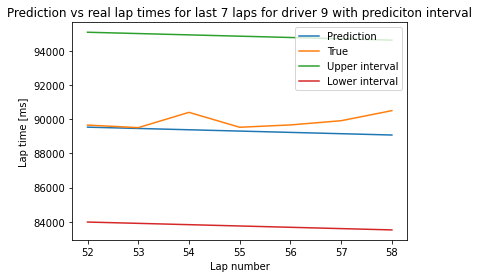

In [8]:
from scipy.stats import t

# Extract XTrain and YTrain for making prediction intervals on the test data:
lapNumbersTraining = trans(np.array([raceData[raceData["lap_number"] <= 51]["lap_number"]]))
lapNumbersTest = trans(np.array([raceData[raceData["lap_number"] > 51]["lap_number"]]))

# Calculate prediction interval for the test data:
upperPredictionIntervalOLS = predictionDriverOLS + t.ppf(1-0.025, N - p) * sigmaOLS \
    * np.sqrt(1 + trans(lapNumbersTest) * 1/(trans(lapNumbersTraining) @ lapNumbersTraining) @ lapNumbersTest)

lowerPredictionIntervalOLS = predictionDriverOLS - t.ppf(1-0.025, N - p) * sigmaOLS \
    * np.sqrt(1 + trans(lapNumbersTest) * 1/(trans(lapNumbersTraining) @ lapNumbersTraining) @ lapNumbersTest)

# Plot predictions, true value and prediction interval:
plt.plot(lapNumbersDriverTest, predictionDriverOLS)
plt.plot(lapNumbersDriverTest, lapTimesDriverTest)
plt.plot(lapNumbersDriverTest, upperPredictionIntervalOLS[0])
plt.plot(lapNumbersDriverTest, lowerPredictionIntervalOLS[0])
plt.title(f"Prediction vs real lap times for last {numTest} laps for driver {driverId} with prediciton interval")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True", "Upper interval", "Lower interval"])

Make prediction intervals on both training and test data for a driver:

#### Make the prediction for a driver on all the data:

In [9]:
# Id of the driver
driverId = 9

# Get the reace data for the driver
raceDataDriver = raceData[raceData["driverId"] == driverId]

lapNumbersDriver = trans(np.array(raceDataDriver["lap_number"]))
lapTimesDriver = trans(np.array(raceDataDriver["lap_time"]))

lapIsPitstopDriver = np.array(raceDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(raceDataDriver["pitstop_lagged"])
firstLapDriver = np.array(raceDataDriver["lap_number"] == 1).astype(int)

predictionAllDataOLS = alphaOLS[driverId - 1] + betaOLS * lapNumbersDriver + deltaOLS * lapIsPitstopDriver \
    + muOLS * lapsLaggingPitStopDriver + phiOLS * firstLapDriver

### Calculate the prediction interval for the driver:

In [10]:
# Make predictions intervals:
upperIntervalDriver  = predictionAllDataOLS + t.ppf(1-0.025, N - p) * sigmaOLS \
    * np.sqrt(1 + (trans(lapNumbersDriver) * 1/(trans(lapNumbersDriver) @ lapNumbersDriver) @ lapNumbersDriver))

lowerIntervalDriver = predictionAllDataOLS - t.ppf(1-0.025, N - p) * sigmaOLS \
    * np.sqrt(1 + (trans(lapNumbersDriver) * 1/(trans(lapNumbersDriver) @ lapNumbersDriver) @ lapNumbersDriver))

### Plot the data with the prediction intervals:

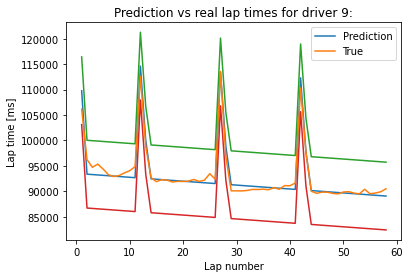

In [11]:
# Plot predictions and true value
plt.plot(lapNumbersDriver, predictionAllDataOLS)
plt.plot(lapNumbersDriver, lapTimesDriver)
plt.plot(lapNumbersDriver, upperIntervalDriver[0])
plt.plot(lapNumbersDriver, lowerIntervalDriver[0])
plt.title(f"Prediction vs real lap times for driver {driverId}:")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True"])

## 1.3 WLS

The covariance matrix are the same for each driver. Thus we have to calculate the covariance matrix for each driver and make the bigger covariance matrix for all drivers.

In [12]:
# Parameter to create covariance matrix:
rho = 0.5


# Create a array with all the covariance matrices for all the drivers:
covMatricesGamma = []
gammaMatrices = []

for driverId in drivers:
    raceDataDriver = raceData[raceData["driverId"] == driverId]
    numLaps = len(raceDataDriver[raceDataDriver["lap_number"] <= 51])

    covMatrix = np.zeros([numLaps, numLaps])
    
    for n in range(numLaps):
        covCol = np.ones(numLaps)
        gammaCol = np.ones(numLaps)
        for i in range(-n, numLaps - n):
            covCol[i+n] = rho**abs(i)
        covMatrix[n] = covCol
    
    covMatricesGamma.append(covMatrix)

# Create the big covariance matrix by placing the prior calculated covarince matrices along the diagonal:
covMatrixAllDrivers = block_diag(*covMatricesGamma)

Now that I hava calculated the covarince matrix I will use WLS to find new parameters:

In [13]:
# Make the model:
parametersWLS = np.linalg.inv((trans(XTrain) @ np.linalg.inv(covMatrixAllDrivers) @ XTrain)) @ trans(XTrain) @ np.linalg.inv(covMatrixAllDrivers) @ YTrain

alphaWLS = parametersWLS[:21]
betaWLS = parametersWLS[21]
deltaWLS = parametersWLS[22] # Parameter for pitstop laps
muWLS = parametersWLS[23] # Parameter for lap lagging pitstop
phiWLS = parametersWLS[24] # Parameter for first lap

<ipython-input-14-9fc040b26886>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]


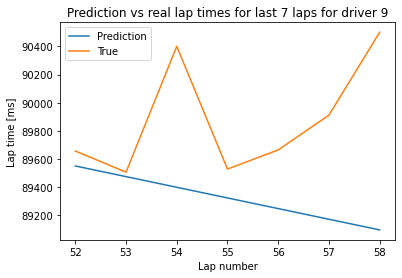

In [14]:
# Id for driver:
driverId = 9

# Extract the race data for the driver:
testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]

# Get the XTest and YTest:
lapNumbersDriverTest = np.array(testDataDriver["lap_number"])
lapTimesDriverTest = np.array(testDataDriver["lap_time"])

lapIsPitstopDriver = np.array(testDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(testDataDriver["pitstop_lagged"])
firstLap = np.array(testDataDriver["lap_number"] == 1).astype(int)

# Make the prediction:
predictionDriverWLS = alphaWLS[driverId - 1] + betaWLS * lapNumbersDriverTest + deltaWLS * lapIsPitstopDriver + muWLS * lapsLaggingPitStopDriver + phiWLS * firstLap

# Plot predictions and true value
plt.plot(lapNumbersDriverTest, predictionDriverWLS)
plt.plot(lapNumbersDriverTest, lapTimesDriverTest)
plt.title(f"Prediction vs real lap times for last {numTest} laps for driver {driverId}")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True"])

### Same as in 1.2:

In [15]:
# Make predictions on the training data for all drivers:
predictionAllDriversWLS = XTrain @ parametersWLS

N = len(YTrain) # Number of samples
p = len(parametersWLS) # Number of parameters

# Calculate the variance sigma2 and std sigma:
sigma2WLS = (trans(YTrain - predictionAllDriversWLS) @ np.linalg.inv(covMatrixAllDrivers) @ (YTrain - predictionAllDriversWLS)) /(N - p)
sigmaWLS = np.sqrt(sigma2WLS)
print(sigmaWLS)

[[2707.12224535]]


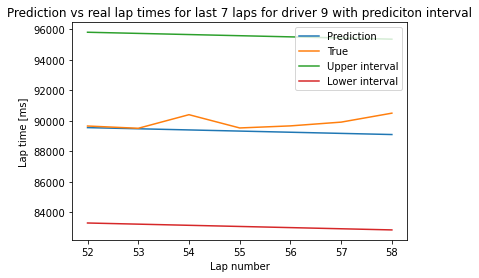

In [16]:
# Extract XTrain and YTrain for making prediction intervals on the test data:
lapNumbersTraining = trans(np.array([raceData[raceData["lap_number"] <= 51]["lap_number"]]))
lapNumbersTest = trans(np.array([raceData[raceData["lap_number"] > 51]["lap_number"]]))

# Calculate prediction interval for the test data:
upperPredictionInterval = predictionDriverWLS + t.ppf(1-0.025, N - p) * sigmaWLS \
    * np.sqrt(1 + trans(lapNumbersTest) * 1/(trans(lapNumbersTraining) @ lapNumbersTraining) @ lapNumbersTest)

lowerPredictionInterval = predictionDriverWLS - t.ppf(1-0.025, N - p) * sigmaWLS \
    * np.sqrt(1 + trans(lapNumbersTest) * 1/(trans(lapNumbersTraining) @ lapNumbersTraining) @ lapNumbersTest)

# Plot predictions, true value and prediction interval:
plt.plot(lapNumbersDriverTest, predictionDriverWLS)
plt.plot(lapNumbersDriverTest, lapTimesDriverTest)
plt.plot(lapNumbersDriverTest, upperPredictionInterval[0])
plt.plot(lapNumbersDriverTest, lowerPredictionInterval[0])
plt.title(f"Prediction vs real lap times for last {numTest} laps for driver {driverId} with prediciton interval")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True", "Upper interval", "Lower interval"])

In [17]:
# Id of the driver
driverId = 9

# Get the reace data for the driver
raceDataDriver = raceData[raceData["driverId"] == driverId]

lapNumbersDriver = trans(np.array(raceDataDriver["lap_number"]))
lapTimesDriver = trans(np.array(raceDataDriver["lap_time"]))

lapIsPitstopDriver = np.array(raceDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(raceDataDriver["pitstop_lagged"])
firstLapDriver = np.array(raceDataDriver["lap_number"] == 1).astype(int)

predictionAllDataWLS = alphaWLS[driverId - 1] + betaWLS * lapNumbersDriver + deltaWLS * lapIsPitstopDriver \
    + muWLS * lapsLaggingPitStopDriver + phiWLS * firstLapDriver

In [18]:
lapNumbersDriver = trans(np.array([raceDataDriver["lap_number"]]))
lapTimesDriver = trans(np.array([raceDataDriver["lap_time"]]))

# Make predictions intervals:
upperIntervalDriverWLS  = predictionAllDataWLS + t.ppf(1-0.025, N - p) * sigmaWLS \
    * np.sqrt(1 + (trans(lapNumbersDriver) * 1/(trans(lapNumbersDriver) @ lapNumbersDriver) @ lapNumbersDriver))

lowerIntervalDriverWLS = predictionAllDataWLS - t.ppf(1-0.025, N - p) * sigmaWLS \
    * np.sqrt(1 + (trans(lapNumbersDriver) * 1/(trans(lapNumbersDriver) @ lapNumbersDriver) @ lapNumbersDriver))

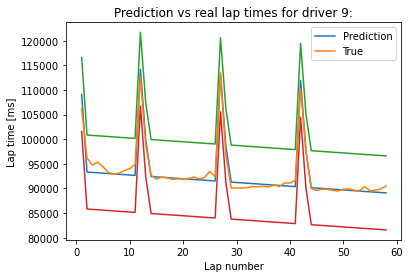

In [19]:
# Plot predictions and true value
plt.plot(lapNumbersDriver, predictionAllDataWLS)
plt.plot(lapNumbersDriver, lapTimesDriver)
plt.plot(lapNumbersDriver, upperIntervalDriverWLS[0])
plt.plot(lapNumbersDriver, lowerIntervalDriverWLS[0])
plt.title(f"Prediction vs real lap times for driver {driverId}:")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True"])

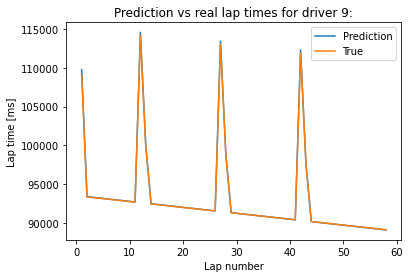

In [20]:
# Plot predictions and true value
plt.plot(lapNumbersDriver, predictionAllDataOLS)
plt.plot(lapNumbersDriver, predictionAllDataWLS)
plt.title(f"Prediction vs real lap times for driver {driverId}:")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True"])

Adjust the covarance matrix by multiplying some of its values:

In [21]:
# Parameter to create covariance matrix:
rho = 0.5

gammaPitstop = 1.5
gammaPistopLagged = 1.5
gammaFirstLap = 1.5

# Create a array with all the covariance matrices for all the drivers:
covMatricesGamma = []
gammaMatrices = []

for driverId in drivers:
    raceDataDriver = raceData[raceData["driverId"] == driverId]
    numLaps = len(raceDataDriver[raceDataDriver["lap_number"] <= 51])

    lapIsPitStop = np.array(raceDataDriver["pitstop"])
    lapLaggingPitStop = np.array(raceDataDriver["pitstop_lagged"]).astype(bool)
    isFirstLap = (np.array(raceDataDriver["lap_number"]) == 1)

    covMatrixGamma = np.zeros([numLaps, numLaps])
    gammaMatrix = np.ones([numLaps, numLaps])
    
    for n in range(numLaps):
        covCol = np.ones(numLaps)
        gammaCol = np.ones(numLaps)
        for i in range(-n, numLaps - n):
            covCol[i+n] = rho**abs(i)
        covMatrixGamma[n] = covCol

        if lapIsPitStop[n]:
            gammaMatrix[n] = gammaCol * gammaPitstop

        if lapLaggingPitStop[n]:
            gammaMatrix[n] = gammaCol * gammaPistopLagged

        if isFirstLap[n]:
            gammaMatrix[n] = gammaCol * gammaFirstLap
    
    covMatricesGamma.append(covMatrixGamma)
    gammaMatrices.append(gammaMatrix)

# Create the big covariance matrix by placing the prior calculated covarince matrices along the diagonal:
gammaMatrixAllDrivers = block_diag(*gammaMatrices)

covMatrixAllDriversGamma = block_diag(*covMatricesGamma) * gammaMatrixAllDrivers * trans(gammaMatrixAllDrivers)

### Train the model with the new covariancve matrix:

In [22]:
# Make the model:
parametersWLSGamma = np.linalg.inv((trans(XTrain) @ np.linalg.inv(covMatrixAllDrivers) @ XTrain)) @ trans(XTrain) @ np.linalg.inv(covMatrixAllDrivers) @ YTrain

alphaWLSGamma = parametersWLSGamma[:21]
betaWLSGamma = parametersWLSGamma[21]
deltaWLSGamma = parametersWLSGamma[22] # Parameter for pitstop laps
muWLSGamma = parametersWLSGamma[23] # Parameter for lap lagging pitstop
phiWLSGamma = parametersWLSGamma[24] # Parameter for first lap

<ipython-input-23-90935245efdd>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]


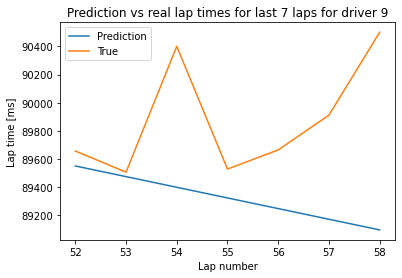

In [23]:
# Id for driver:
driverId = 9

# Extract the race data for the driver:
testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]

# Get the XTest and YTest:
lapNumbersDriverTest = np.array(testDataDriver["lap_number"])
lapTimesDriverTest = np.array(testDataDriver["lap_time"])

lapIsPitstopDriver = np.array(testDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(testDataDriver["pitstop_lagged"])
firstLap = np.array(testDataDriver["lap_number"] == 1).astype(int)

# Make the prediction:
predictionDriverWLSGamma = alphaWLSGamma[driverId - 1] + betaWLSGamma * lapNumbersDriverTest + deltaWLSGamma * lapIsPitstopDriver \
    + muWLSGamma * lapsLaggingPitStopDriver + phiWLSGamma * firstLap

# Plot predictions and true value
plt.plot(lapNumbersDriverTest, predictionDriverWLSGamma)
plt.plot(lapNumbersDriverTest, lapTimesDriverTest)
plt.title(f"Prediction vs real lap times for last {numTest} laps for driver {driverId}")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True"])

In [24]:
# Make predictions on the training data for all drivers:
predictionAllDriversWLSGamma = XTrain @ parametersWLSGamma

N = len(YTrain) # Number of samples
p = len(parametersWLSGamma) # Number of parameters

# Calculate the variance sigma2 and std sigma:
sigma2WLSGamma = (trans(YTrain - predictionAllDriversWLSGamma) @ np.linalg.inv(covMatrixAllDriversGamma) @(YTrain - predictionAllDriversWLSGamma)) /(N - p)
sigmaWLSGamma = np.sqrt(sigma2WLSGamma)
print(sigmaWLSGamma)

[[2008.01759129]]


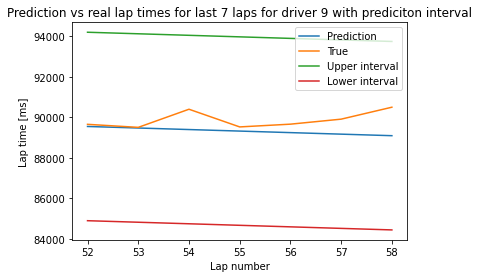

In [25]:
# Extract XTrain and YTrain for making prediction intervals on the test data:
lapNumbersTraining = trans(np.array([raceData[raceData["lap_number"] <= 51]["lap_number"]]))
lapNumbersTest = trans(np.array([raceData[raceData["lap_number"] > 51]["lap_number"]]))

# Calculate prediction interval for the test data:
upperPredictionInterval = predictionDriverWLSGamma + t.ppf(1-0.025, N - p) * sigmaWLSGamma \
    * np.sqrt(1 + trans(lapNumbersTest) * 1/(trans(lapNumbersTraining) @ lapNumbersTraining) @ lapNumbersTest)

lowerPredictionInterval = predictionDriverWLSGamma - t.ppf(1-0.025, N - p) * sigmaWLSGamma \
    * np.sqrt(1 + trans(lapNumbersTest) * 1/(trans(lapNumbersTraining) @ lapNumbersTraining) @ lapNumbersTest)

# Plot predictions, true value and prediction interval:
plt.plot(lapNumbersDriverTest, predictionDriverWLSGamma)
plt.plot(lapNumbersDriverTest, lapTimesDriverTest)
plt.plot(lapNumbersDriverTest, upperPredictionInterval[0])
plt.plot(lapNumbersDriverTest, lowerPredictionInterval[0])
plt.title(f"Prediction vs real lap times for last {numTest} laps for driver {driverId} with prediciton interval")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True", "Upper interval", "Lower interval"])

In [26]:
# Id of the driver
driverId = 9

# Get the reace data for the driver
raceDataDriver = raceData[raceData["driverId"] == driverId]

lapNumbersDriver = trans(np.array(raceDataDriver["lap_number"]))
lapTimesDriver = trans(np.array(raceDataDriver["lap_time"]))

lapIsPitstopDriver = np.array(raceDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(raceDataDriver["pitstop_lagged"])
firstLapDriver = np.array(raceDataDriver["lap_number"] == 1).astype(int)

predictionAllDataWLSGamma = alphaWLSGamma[driverId - 1] + betaWLSGamma * lapNumbersDriver + deltaWLSGamma * lapIsPitstopDriver \
    + muWLSGamma * lapsLaggingPitStopDriver + phiWLSGamma * firstLapDriver

In [27]:
# Make predictions intervals:
upperIntervalDriver  = predictionAllDataWLSGamma + t.ppf(1-0.025, N - p) * sigmaWLSGamma \
    * np.sqrt(1 + (trans(lapNumbersDriver) * 1/(trans(lapNumbersDriver) @ lapNumbersDriver) @ lapNumbersDriver))

lowerIntervalDriver = predictionAllDataWLSGamma - t.ppf(1-0.025, N - p) * sigmaWLSGamma \
    * np.sqrt(1 + (trans(lapNumbersDriver) * 1/(trans(lapNumbersDriver) @ lapNumbersDriver) @ lapNumbersDriver))

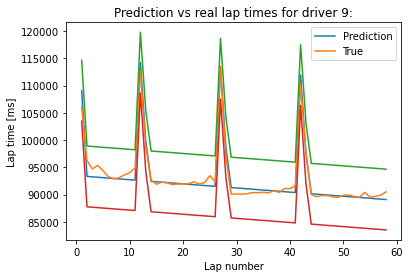

In [28]:
# Plot predictions and true value
plt.plot(lapNumbersDriver, predictionAllDataWLSGamma)
plt.plot(lapNumbersDriver, lapTimesDriver)
plt.plot(lapNumbersDriver, upperIntervalDriver[0])
plt.plot(lapNumbersDriver, lowerIntervalDriver[0])
plt.title(f"Prediction vs real lap times for driver {driverId}:")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True"])

## 1.4 Optimal covariance matrix

First I need to create the X matrix for training:

In [35]:
# Number of iterations in calculating the covariance matrix:
iterations  = 5

# Parameter to create covariance matrix:
rho = 0.5

# Create a array with all the covariance matrices for all the drivers:
covMatrices = []

for driverId in drivers:
    raceDataDriver = raceData[raceData["driverId"] == driverId]
    numLaps = len(raceDataDriver[raceDataDriver["lap_number"] <= numTrain])
    covMatrix = np.zeros([numLaps, numLaps])
    
    for n in range(numLaps):
        covCol = np.ones(numLaps)
        for i in range(-n, numLaps - n):
            covCol[i+n] = rho**abs(i)
        covMatrix[n] = covCol
    
    covMatrices.append(covMatrix)

# Create the big covariance matrix by placing the prior calculated covarince matrices along the diagonal:
optimalCovMatrixAllDrivers = block_diag(*covMatrices)

optimalParameters = np.linalg.inv((trans(XTrain) @ optimalCovMatrixAllDrivers @ XTrain)) @ trans(XTrain) @ optimalCovMatrixAllDrivers @ YTrain

# Iterate and update:
for i in range(iterations):
    # Make prediction:
    optimalPrediction = XTrain @ optimalParameters

    # Extract pitstop laps, laps lagging pitstop and first laps:
    predictionTimesPit = optimalPrediction * lapIsPitstopTrain
    predictionTimesLag = optimalPrediction * lapIsLaggingPitstopTrain
    predictionTimesFirst = optimalPrediction * lapIsFirstLapTrain
    predictionTimesNormal = optimalPrediction * np.invert(lapIsPitstopTrain) * np.invert(lapIsLaggingPitstopTrain) * np.invert(lapIsFirstLapTrain)

    YTrainPit = YTrain * lapIsPitstopTrain
    YTrainLag = YTrain * lapIsLaggingPitstopTrain
    YTrainFirst = YTrain * lapIsFirstLapTrain
    YTrainNormal = YTrain * np.invert(lapIsPitstopTrain) * np.invert(lapIsLaggingPitstopTrain) * np.invert(lapIsFirstLapTrain)

    # Calculate epsilon:
    epsilonPit = np.sum(abs(predictionTimesPit - YTrainPit)) / (numPitstopTrain)
    epsilonLag = np.sum(abs(predictionTimesLag - YTrainLag)) / (numLaggedPitstopTrain)
    epsilonFirst = np.sum(abs(predictionTimesFirst - YTrainFirst)) / (numFirstLapTrain)
    epsilonNormal = np.sum(abs(predictionTimesNormal - YTrainNormal)) / (numNormalLaps)

    epsilonAll = np.sum(abs(optimalPrediction - YTrain))

    rho = epsilonNormal / (epsilonPit + epsilonLag + epsilonFirst)

    gammaPitstop = epsilonPit / (epsilonNormal)
    gammaPistopLagged = epsilonLag / (epsilonNormal)
    gammaFirstLap = epsilonFirst / (epsilonNormal)

    # Create the new covariance matrix:
    covMatricesGamma = []
    gammaMatrices = []

    for driverId in drivers:
        raceDataDriver = raceData[raceData["driverId"] == driverId]
        numLaps = len(raceDataDriver[raceDataDriver["lap_number"] <= 51])

        lapIsPitStop = np.array(raceDataDriver["pitstop"])
        lapLaggingPitStop = np.array(raceDataDriver["pitstop_lagged"]).astype(bool)
        isFirstLap = (np.array(raceDataDriver["lap_number"]) == 1)

        covMatrixGamma = np.zeros([numLaps, numLaps])
        gammaMatrix = np.ones([numLaps, numLaps])
        
        for n in range(numLaps):
            covCol = np.ones(numLaps)
            gammaCol = np.ones(numLaps)
            for i in range(-n, numLaps - n):
                covCol[i+n] = rho**abs(i)
            covMatrixGamma[n] = covCol

            if lapIsPitStop[n]:
                gammaMatrix[n] = gammaCol * gammaPitstop

            if lapLaggingPitStop[n]:
                gammaMatrix[n] = gammaCol * gammaPistopLagged

            if isFirstLap[n]:
                gammaMatrix[n] = gammaCol * gammaFirstLap
        
        covMatricesGamma.append(covMatrixGamma)
        gammaMatrices.append(gammaMatrix)

    # Create the big covariance matrix by placing the prior calculated covariance matrices along the diagonal:
    gammaMatrixAllDrivers = block_diag(*gammaMatrices)

    # Add gamma parameters:
    optimalCovMatrixAllDrivers = block_diag(*covMatricesGamma) * gammaMatrixAllDrivers * trans(gammaMatrixAllDrivers)
 
    # Recalculate parameters:
    optimalParameters = np.linalg.inv((trans(XTrain) @ np.linalg.inv(optimalCovMatrixAllDrivers) @ XTrain)) @ trans(XTrain) @ np.linalg.inv(optimalCovMatrixAllDrivers) @ YTrain

alphaOptimal = optimalParameters[:21]
betaOptimal = optimalParameters[21]
deltaOptimal = optimalParameters[22] # Parameter for pitstop laps
muOptimal = optimalParameters[23] # Parameter for lap lagging pitstop
phiOptimal = optimalParameters[24] # Parameter for first lap

<ipython-input-36-c0de98fb640e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]


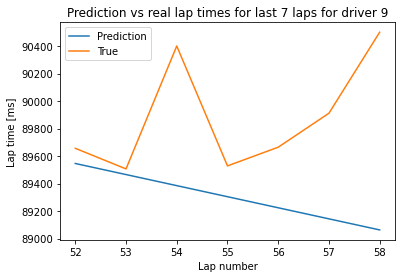

In [36]:
# Id for driver:
driverId = 9

# Extract the race data for the driver:
testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]

# Get the XTest and YTest:
lapNumbersDriverTest = np.array(testDataDriver["lap_number"])
lapTimesDriverTest = np.array(testDataDriver["lap_time"])

lapIsPitstopDriver = np.array(testDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(testDataDriver["pitstop_lagged"])
firstLap = np.array(testDataDriver["lap_number"] == 1).astype(int)

# Make the prediction:
predictionDriverOptimal = alphaOptimal[driverId - 1] + betaOptimal * lapNumbersDriverTest + deltaOptimal * lapIsPitstopDriver \
    + muOptimal * lapsLaggingPitStopDriver + phiOptimal * firstLap

# Plot predictions and true value
plt.plot(lapNumbersDriverTest, predictionDriverOptimal)
plt.plot(lapNumbersDriverTest, lapTimesDriverTest)
plt.title(f"Prediction vs real lap times for last {numTest} laps for driver {driverId}")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True"])

In [37]:
# Make predictions on the training data for all drivers:
optimalPrediction = XTrain @ optimalParameters

N = len(YTrain) # Number of samples
p = len(optimalParameters) # Number of parameters

# Calculate the variance sigma2 and std sigma:
sigma2Optimal = (trans(YTrain - optimalPrediction) @ np.linalg.inv(optimalCovMatrixAllDrivers) @ (YTrain - optimalPrediction)) /(N - p)
sigmaOptimal = np.sqrt(sigma2Optimal)
print(sigmaOptimal)

[[1353.15170765]]


Make prediction interval for whole data set:

In [32]:
# Id of the driver
driverId = 9

# Get the reace data for the driver
raceDataDriver = raceData[raceData["driverId"] == driverId]

lapNumbersDriver = trans(np.array(raceDataDriver["lap_number"]))
lapTimesDriver = trans(np.array(raceDataDriver["lap_time"]))

lapIsPitstopDriver = np.array(raceDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(raceDataDriver["pitstop_lagged"])
firstLapDriver = np.array(raceDataDriver["lap_number"] == 1).astype(int)

optimalPredictionDriver = alphaOptimal[driverId - 1] + betaOptimal * lapNumbersDriver + deltaOptimal * lapIsPitstopDriver \
    + muOptimal * lapsLaggingPitStopDriver + phiOptimal * firstLapDriver

In [33]:
# Make predictions intervals:
upperIntervalDriverOptimal  = optimalPredictionDriver + t.ppf(1-0.025, N - p) * sigmaOptimal \
    * np.sqrt(1 + (trans(lapNumbersDriver) * 1/(trans(lapNumbersDriver) @ lapNumbersDriver) @ lapNumbersDriver))

lowerIntervalDriverOptimal = optimalPredictionDriver - t.ppf(1-0.025, N - p) * sigmaOptimal \
    * np.sqrt(1 + (trans(lapNumbersDriver) * 1/(trans(lapNumbersDriver) @ lapNumbersDriver) @ lapNumbersDriver))

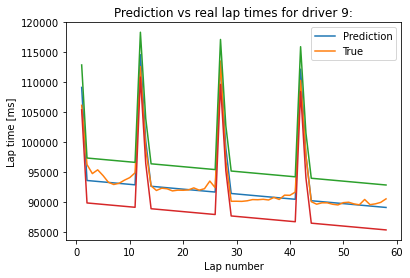

In [34]:
# Plot predictions and true value
plt.plot(lapNumbersDriver, optimalPredictionDriver)
plt.plot(lapNumbersDriver, lapTimesDriver)
plt.plot(lapNumbersDriver, upperIntervalDriverOptimal[0])
plt.plot(lapNumbersDriver, lowerIntervalDriverOptimal[0])
plt.title(f"Prediction vs real lap times for driver {driverId}:")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True"])